# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries
#!pip install tensorflow
import numpy as np
print("NumPy version:", np.__version__)

import pandas as pd
print("Pandas version:", pd.__version__)

import seaborn as sns
print("Seaborn version:", sns.__version__)

import matplotlib as mpl
print("Matplotlib version:", mpl.__version__)
import matplotlib.pyplot as plt

import PIL
from PIL import Image
print("PIL (Pillow) version:", PIL.__version__)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print("TensorFlow version:", tf.__version__)

from tensorflow import keras
print("Keras version:", keras.__version__)

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
print("Scikit-learn version:", sklearn.__version__)

import os
from google.colab import drive
import zipfile
from tqdm import tqdm



NumPy version: 2.0.2
Pandas version: 2.2.2
Seaborn version: 0.13.2
Matplotlib version: 3.10.0
PIL (Pillow) version: 11.1.0
TensorFlow version: 2.18.0
Keras version: 3.8.0
Scikit-learn version: 1.6.1


Load the dataset.

In [3]:
# Load and unzip the dataset
drive.mount('/content/drive/')
data_zip_path = "/content/drive/MyDrive/Colab Notebooks/CNN_Assingenment/data.zip"
extracted_folder_path = "/content"

with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Define data directories
data_dir = os.path.join(extracted_folder_path, 'data')

Mounted at /content/drive/


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_images_from_folder(folder_path):
    images = []
    labels = []
    class_names = os.listdir(folder_path)

    for class_name in tqdm(class_names, desc="Processing Classes"):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            image_files = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in tqdm(image_files, desc=f"Loading {class_name}", leave=False):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    images.append(np.array(img))
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels

raw_images, raw_labels = load_images_from_folder(data_dir)
raw_images.shape, raw_labels.shape

Processing Classes: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


((7625, 256, 256, 3), (7625,))

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

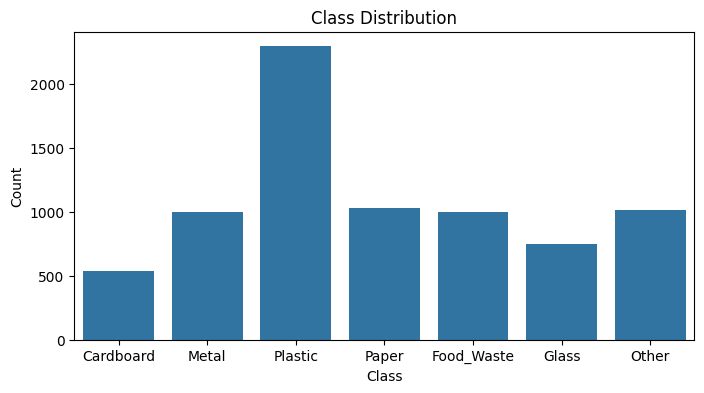

In [6]:
# Visualise Data Distribution

label_df = pd.DataFrame(raw_labels, columns=["labels"])
plt.figure(figsize=(8, 4))
sns.countplot(data=label_df, x="labels")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
7


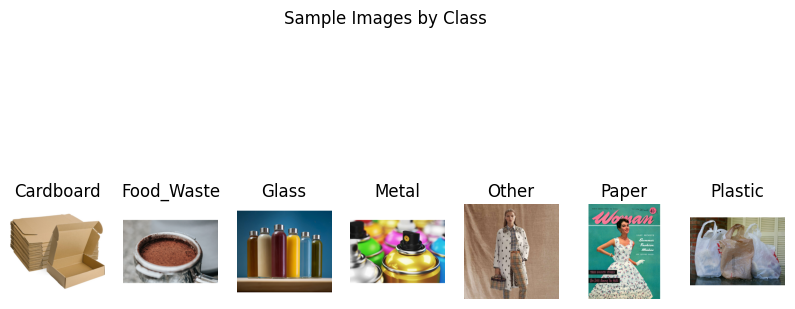

In [7]:
# Visualise Sample Images (across different labels)
unique_classes = np.unique(raw_labels)
num_classes = len(unique_classes)
print(unique_classes)
print(num_classes)
plt.figure(figsize=(10, 5))
for i, cls in enumerate(unique_classes):
    idx = np.where(raw_labels == cls)[0][0]
    plt.subplot(1, 7, i+1)
    plt.imshow(raw_images[idx])
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Sample Images by Class')
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set

min_width = float('inf')
min_height = float('inf')
max_width = 0
max_height = 0

for img in raw_images:
    width, height = Image.fromarray(img).size
    min_width = min(min_width, width)
    min_height = min(min_height, height)
    max_width = max(max_width, width)
    max_height = max(max_height, height)


print("Min Width:", min_width)
print("Min Height:", min_height)
print("Max Width:", max_width)
print("Max Height:", max_height)

Min Width: 256
Min Height: 256
Max Width: 256
Max Height: 256


In [9]:
# Resize the image dimensions

# Resize based on min/max shape (standardize to 224x224)
#
image_size = 224
images_resized = np.array([np.array(Image.fromarray(img).resize((image_size, image_size))) for img in raw_images])
print(images_resized.shape)
print(type(images_resized))

(7625, 224, 224, 3)
<class 'numpy.ndarray'>


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably
# ---- Encoding the classes [3 Marks] ----
le = LabelEncoder()
labels_encoded = le.fit_transform(raw_labels)
labels_encoded_cat = to_categorical(labels_encoded, num_classes=len(unique_classes))
print(labels_encoded_cat[0])
print(labels_encoded_cat)
print(labels_encoded_cat.shape)
print(type(labels_encoded_cat.shape))

[1. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(7625, 7)
<class 'tuple'>


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
X = np.stack([np.array(img) for img in images_resized])  # shape: (N, 224, 224, 3)
y = np.array(labels_encoded_cat)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=labels_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.176, stratify=y_train, random_state=42)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(np.array(X_train), y_train, batch_size=32, shuffle=True)
test_generator  = datagen.flow(np.array(X_test), y_test, batch_size=32, shuffle=False)
val_generator   = datagen.flow(np.array(X_val), y_val, batch_size=32, shuffle=False)
print('train samples:', train_generator.n)
print('Validation samples:', val_generator.n)
print('test samples', test_generator.n)


train samples: 5340
Validation samples: 1141
test samples 1144


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [12]:
# Build and compile the model

configurations = [
    {'name': 'Config 1', 'filters': [32, 64, 128, 128], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]},
    {'name': 'Config 2', 'filters': [32, 32, 64, 128], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]},
    {'name': 'Config 3', 'filters': [32, 64, 64, 128], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]},
    {'name': 'Config 4', 'filters': [32, 64, 128, 256], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]},
    {'name': 'Config 5', 'filters': [64, 128, 128, 512], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]}

]


def create_model(config, input_shape, num_classes):
    model = Sequential()

    for i in range(config['conv_layers']):
        if i == 0:
            model.add(Input(shape=input_shape))
            model.add(Conv2D(config['filters'][i], config['kernel_size'], activation=config['activation']))
        else:
            model.add(Conv2D(config['filters'][i], config['kernel_size'], activation=config['activation']))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=config['pool_size']))
        model.add(Dropout(config['dropout_rate'][0]))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(config['dropout_rate'][1]))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(config['dropout_rate'][1]))
    model.add(Dense(num_classes, activation='softmax'))

    return model


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [14]:
# Training the model
best_accuracy = 0
best_config = None
best_config_name = None
best_model = None
epochs = 20
batch_size = 16
input_shape = (image_size, image_size, 3)
num_classes = len(unique_classes)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6)
]

history_dict = {}
for config in (configurations):
    model = create_model(config, input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {config['name']}")
    history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=val_generator, callbacks=callbacks)
    history_dict[config['name']] = history.history
    val_loss, val_acc = model.evaluate(val_generator)
    print(f"Validation Loss {config['name']} : {val_loss}, Validation Accuracy {config['name']}: {val_acc}")
    train_loss, train_acc = model.evaluate(train_generator)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_train_accuracy = train_acc
        best_model = model
        best_config_name = config['name']
        best_config = config

Training Config 1
Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.2271 - loss: 6.8555 - val_accuracy: 0.3006 - val_loss: 3.9125 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2986 - loss: 3.5513 - val_accuracy: 0.3006 - val_loss: 2.7704 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3070 - loss: 2.6171 - val_accuracy: 0.3006 - val_loss: 2.2805 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2967 - loss: 2.2273 - val_accuracy: 0.3006 - val_loss: 2.0793 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2947 - loss: 2.0782 - val_accuracy: 0.2997 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3039 - loss: 2.0501 - val_accuracy: 0.3006 - val_loss: 1.9397 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy

In [15]:
print(f"\n✅ Best Model: {best_config_name}")
print(f"   Training Accuracy:   {best_train_accuracy:.4f}")
print(f"   Validation Accuracy: {best_accuracy:.4f}")
print(f"   Best Config : {best_config}")


✅ Best Model: Config 1
   Training Accuracy:   0.5650
   Validation Accuracy: 0.5118
   Best Config : {'name': 'Config 1', 'filters': [32, 64, 128, 128], 'conv_layers': 4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': [0.25, 0.5]}


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.61      0.60      0.61        81
  Food_Waste       0.74      0.54      0.62       150
       Glass       0.64      0.43      0.51       112
       Metal       0.41      0.65      0.50       150
       Other       0.72      0.19      0.30       152
       Paper       0.65      0.30      0.41       155
     Plastic       0.51      0.79      0.62       344

    accuracy                           0.55      1144
   macro avg       0.61      0.50      0.51      1144
weighted avg       0.60      0.55      0.52      1144



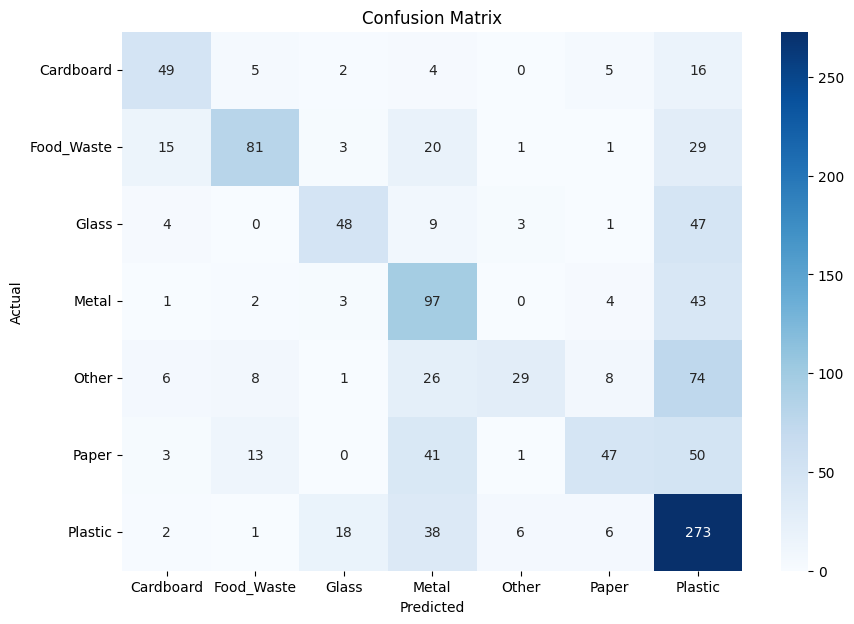

In [16]:
# Evaluate on the test set; display suitable metrics

y_pred_test = best_model.predict(test_generator)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [17]:
# Create the augmented training dataset

X = np.stack([np.array(img) for img in images_resized])  # shape: (N, 224, 224, 3)
y = np.array(labels_encoded_cat)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=labels_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.176, stratify=y_train, random_state=42)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow(np.array(X_train), y_train, batch_size=32, shuffle=True)
print('train samples:', train_generator.n)
print('Validation samples:', val_generator.n)
print('test samples', test_generator.n)

train samples: 5340
Validation samples: 1141
test samples 1144


##### **4.1.2**

Train the model on the new augmented dataset.

Training Config 1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.2239 - loss: 7.0556 - val_accuracy: 0.3006 - val_loss: 4.2185 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - accuracy: 0.2924 - loss: 3.8013 - val_accuracy: 0.3006 - val_loss: 2.9180 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - accuracy: 0.2961 - loss: 2.7542 - val_accuracy: 0.2997 - val_loss: 2.3906 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - accuracy: 0.3001 - loss: 2.3235 - val_accuracy: 0.3006 - val_loss: 2.1451 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - accuracy: 0.2962 - loss: 2.1205 - val_accuracy: 0.3006 - val_loss: 2.0191 - learning_rate: 0.0010
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - accuracy: 0.3087 - loss: 2.0055 - val_accuracy: 0.2962 - val_loss: 1.9640 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - accuracy: 0.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


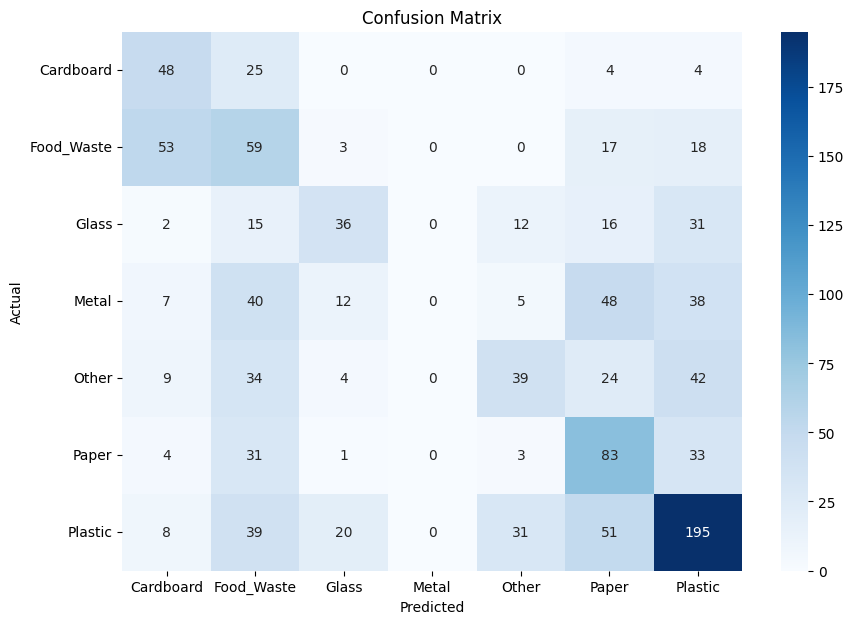

In [18]:
# Train the model using augmented images
best_model = create_model(best_config, input_shape, num_classes)
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(f"Training {best_config_name}")
history = best_model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

# Evaluate on the test set; display suitable metrics
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss {best_config_name} : {test_loss}, Test Accuracy {best_config_name}: {test_acc}")
y_pred_test = best_model.predict(test_generator)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data

Dataset Overview:
The dataset contains 7 waste classes:

Cardboard

Food Waste

Glass

Metal

Other

Paper

Plastic

Class Distribution (from visualizations):
Some classes (e.g. Plastic, Food Waste) are overrepresented.
Others like Other, Glass have fewer examples.
This class imbalance affects the model's performance.

Image Information:
Images were resized to 224x224

Converted to RGB format

Normalized to [0, 1] using rescale=1./255

One-hot encoded labels using to_categorical

* Report model training results

Model Configuration:
CNN with:

3–4 Conv2D layers

Dropout layers (to reduce overfitting)

Final Dense layer with softmax activation

Optimizer: adam

Loss function: categorical_crossentropy

Evaluation: accuracy

🔁 Data Augmentation Used:
Rotation, width/height shift, shear, zoom, flip

Validation data was not augmented (good practice)

🧪 Results from Confusion Matrix (latest run):
Plastic: well-classified (273 correct)

Glass, Other, Paper: often misclassified as Plastic

Food Waste and Metal: also show some confusion with others

📉 Training Accuracy, Validation and Test Accuracy:
Final training accuracy around: 50%–55%
Validation accuracy: 45 - 50 %
Test accuracy: 40% - 45 %

Some overfitting signs observed (train ≫ val accuracy)